In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

In [26]:
crypto_currency = 'BTC'
against_currency = 'USD'
start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

data = yf.download(f'{crypto_currency}-{against_currency}', start=start, end=end)

<ipython-input-26-2214560567>:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(f'{crypto_currency}-{against_currency}', start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [27]:
print(data)

Price               Close           High            Low           Open  \
Ticker            BTC-USD        BTC-USD        BTC-USD        BTC-USD   
Date                                                                     
2016-01-01     434.334015     436.246002     427.515015     430.721008   
2016-01-02     433.437988     436.062012     431.869995     434.622009   
2016-01-03     430.010986     433.743011     424.705994     433.578003   
2016-01-04     433.091003     434.516998     429.084015     430.061005   
2016-01-05     431.959991     434.182007     429.675995     433.069000   
...                   ...            ...            ...            ...   
2025-06-14  105472.406250  106203.757812  104379.367188  106108.085938   
2025-06-15  105552.023438  106157.101562  104519.882812  105464.843750   
2025-06-16  106796.757812  108915.375000  104997.625000  105555.593750   
2025-06-17  104601.117188  107750.195312  103396.531250  106794.117188   
2025-06-18  104433.351562  105539.2187

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3457 entries, 2016-01-01 to 2025-06-18
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3457 non-null   float64
 1   (High, BTC-USD)    3457 non-null   float64
 2   (Low, BTC-USD)     3457 non-null   float64
 3   (Open, BTC-USD)    3457 non-null   float64
 4   (Volume, BTC-USD)  3457 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 162.0 KB


In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

In [29]:
prediction_days = 60
future_days = 30

X_train, y_train = [], []
for x in range(prediction_days, len(scaled_data) - future_days):
    X_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x + future_days, 0])

In [30]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [31]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [32]:
class CryptoDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [33]:
train_loader = DataLoader(CryptoDataset(X_train, y_train), batch_size=32, shuffle=True)

In [34]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=50, batch_first=True, dropout=0.2, num_layers=1)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True, dropout=0.2, num_layers=1)
        self.lstm3 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True, num_layers=1)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x, _ = self.lstm3(x)
        x = x[:, -1, :]  # last time step
        x = self.dropout(x)
        return self.fc(x)

In [35]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [36]:
model.train()
for epoch in range(25):
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} / 25 - Loss: {running_loss / len(train_loader):.4f}")

Epoch 1 / 25 - Loss: 0.0500
Epoch 2 / 25 - Loss: 0.0072
Epoch 3 / 25 - Loss: 0.0059
Epoch 4 / 25 - Loss: 0.0061
Epoch 5 / 25 - Loss: 0.0058
Epoch 6 / 25 - Loss: 0.0056
Epoch 7 / 25 - Loss: 0.0057
Epoch 8 / 25 - Loss: 0.0056
Epoch 9 / 25 - Loss: 0.0051
Epoch 10 / 25 - Loss: 0.0054
Epoch 11 / 25 - Loss: 0.0053
Epoch 12 / 25 - Loss: 0.0052
Epoch 13 / 25 - Loss: 0.0050
Epoch 14 / 25 - Loss: 0.0048
Epoch 15 / 25 - Loss: 0.0050
Epoch 16 / 25 - Loss: 0.0048
Epoch 17 / 25 - Loss: 0.0047
Epoch 18 / 25 - Loss: 0.0046
Epoch 19 / 25 - Loss: 0.0046
Epoch 20 / 25 - Loss: 0.0044
Epoch 21 / 25 - Loss: 0.0046
Epoch 22 / 25 - Loss: 0.0044
Epoch 23 / 25 - Loss: 0.0044
Epoch 24 / 25 - Loss: 0.0044
Epoch 25 / 25 - Loss: 0.0043


In [38]:
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()

test_data = yf.download(f'{crypto_currency}-{against_currency}', start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

X_test = []
for x in range(prediction_days, len(model_inputs)):
    X_test.append(model_inputs[x - prediction_days:x, 0])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

<ipython-input-38-535498965>:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test_data = yf.download(f'{crypto_currency}-{against_currency}', start=test_start, end=test_end)
[*********************100%***********************]  1 of 1 completed


In [42]:
real_data = model_inputs[-prediction_days:]  # shape: (60, 1)
real_data = np.expand_dims(real_data, axis=0) # shape: (1, 60, 1)
real_data_tensor = torch.tensor(real_data, dtype=torch.float32)

In [44]:
model.eval()
with torch.no_grad():
    next_day_pred = model(real_data_tensor).cpu().numpy()

In [45]:
next_day_price = scaler.inverse_transform(next_day_pred)
print(f"Next day predicted price: ${next_day_price[0][0]:.2f}")

Next day predicted price: $97621.86


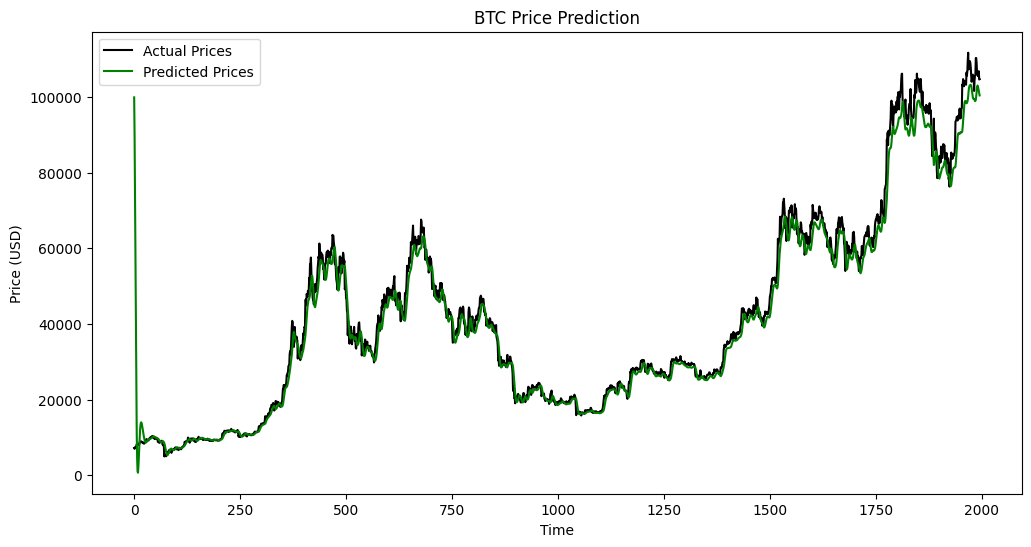

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()